In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


# EDA for Caltech Garage

In [35]:
from datetime import datetime
import numpy as np
import pandas as pd
import pytz

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

la_tz = pytz.timezone('America/Los_Angeles')
format = '%Y-%m-%d'

from sustaingym.envs.evcharging import utils

In [31]:
seasons = ['Summer 2019', 'Fall 2019', 'Spring 2020', 'Summer 2021']

periods = [
    (datetime.strptime(utils.DEFAULT_PERIOD_TO_RANGE[season][0], format).replace(tzinfo=la_tz),
     datetime.strptime(utils.DEFAULT_PERIOD_TO_RANGE[season][1], format).replace(tzinfo=la_tz))
    for season in seasons]

dfs = [utils.get_real_events(period[0], period[1], 'caltech') for period in periods]

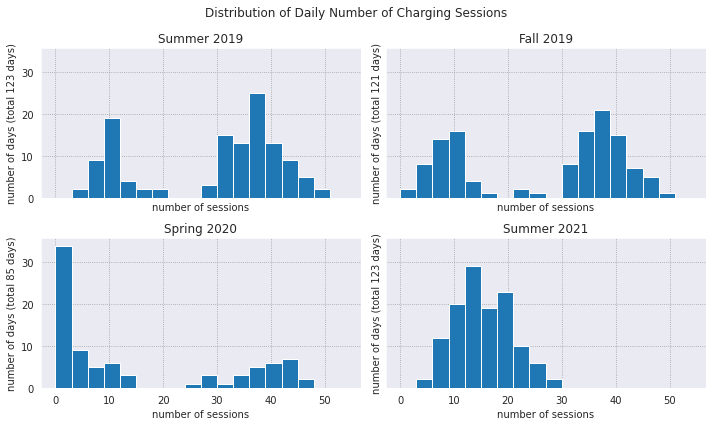

In [95]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 6))
nbins = np.linspace(0, 54, 19)

fig.suptitle('Distribution of Daily Number of Charging Sessions')
for i, pos in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    axs[pos[0], pos[1]].set_title(f'{seasons[i]}')
    axs[pos[0], pos[1]].hist(dfs[i].arrival.dt.dayofyear.value_counts(), bins=nbins)

    axs[pos[0], pos[1]].set_ylabel(f'number of days (total {dfs[i].arrival.dt.dayofyear.nunique()} days)')
    axs[pos[0], pos[1]].set_xlabel('number of sessions')
plt.tight_layout()

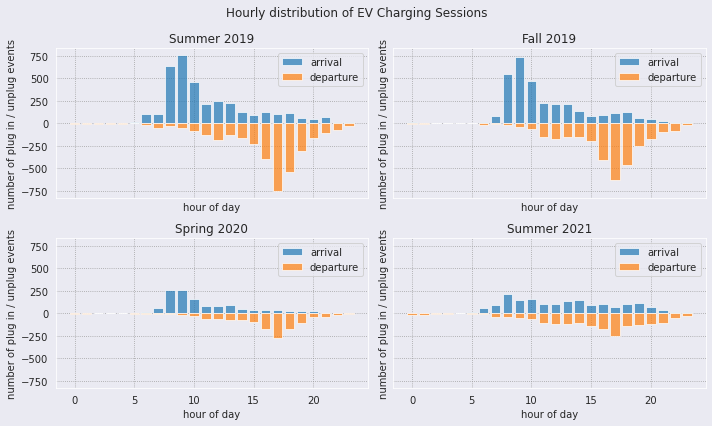

In [96]:
def get_arrs_deps(i):
    arrs, deps = [], []
    arrs_vcs = dfs[i].arrival.dt.hour.value_counts().sort_index()
    deps_vcs = dfs[i].departure.dt.hour.value_counts().sort_index()
    for h in range(0, 24):
        for cnt, series in zip([arrs, deps], [arrs_vcs, deps_vcs]):
            if h in set(series.index):
                cnt.append(series.loc[h])
            else:
                cnt.append(0)
    return np.array(arrs), np.array(deps)

font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
title0 = 'Arrivals'
title1 = 'Departures'

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 6), facecolor=facecolor)
fig.tight_layout()
fig.suptitle('Hourly distribution of EV Charging Sessions')

hrs = [h for h in range(24)]

for i, pos in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    arrs, deps = get_arrs_deps(i)
    axs[pos[0], pos[1]].set_title(f'{seasons[i]}')
    axs[pos[0], pos[1]].bar(hrs, arrs, align='center', zorder=10, alpha=0.7, label='arrival')
    axs[pos[0], pos[1]].bar(hrs, -deps, align='center', zorder=10, alpha=0.7, label='departure')

    axs[pos[0], pos[1]].set_xlabel('hour of day')
    axs[pos[0], pos[1]].set_ylabel(f'number of plug in / unplug events')

    axs[pos[0], pos[1]].legend(bbox_to_anchor=(1, 1))

plt.tight_layout()

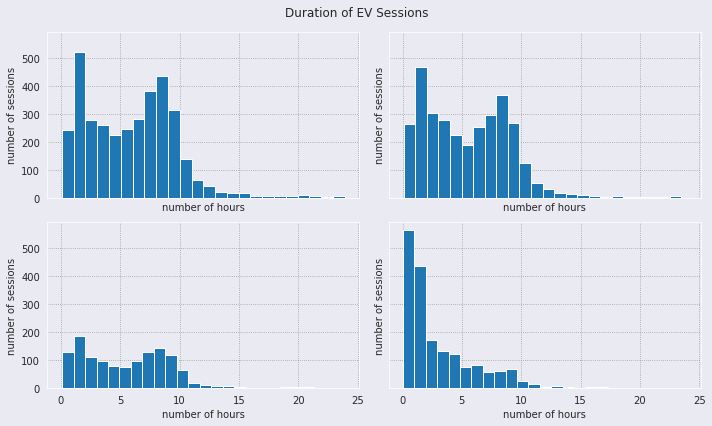

In [145]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 6), facecolor=facecolor)
fig.tight_layout()
fig.suptitle('Duration of EV Sessions')

duration_hrs = (dfs[0].departure - dfs[0].arrival).dt.seconds / 3600

for i, pos in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    duration_hrs = (dfs[i].departure - dfs[i].arrival).dt.seconds / 3600
    axs[pos[0], pos[1]].hist(duration_hrs, bins=24)
    
    axs[pos[0], pos[1]].set_xlabel('number of hours')
    axs[pos[0], pos[1]].set_ylabel('number of sessions')


plt.tight_layout()

173 overnight sessions of 3527 sessions = 4.91 % overnight stays
102 overnight sessions of 3177 sessions = 3.21 % overnight stays
38 overnight sessions of 1269 sessions = 2.99 % overnight stays
43 overnight sessions of 1829 sessions = 2.35 % overnight stays


<BarContainer object of 4 artists>

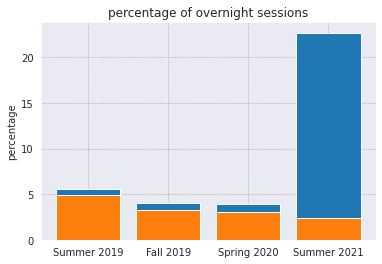

In [114]:
# percentage of sessions 

pcts = []
pcts_est = []
for i, season in enumerate(seasons):
    num_overnight = len(dfs[i][(dfs[i].arrival.dt.dayofyear != dfs[i].departure.dt.dayofyear)])
    num_est_overnight = len(dfs[i][(dfs[i].arrival.dt.dayofyear != dfs[i].departure.dt.dayofyear) | 
                                   ((dfs[i].arrival.dt.dayofyear != dfs[i].estimated_departure.dt.dayofyear))])

    total = len(dfs[i])
    pct = 100 * num_overnight / total
    print(f'{num_overnight} overnight sessions of {total} sessions = {pct:.2f} % overnight stays')

    pcts.append(pct)
    pcts_est.append(100 * num_est_overnight / total)


pcts = np.array(pcts)
plt.title('percentage of overnight sessions')
plt.ylabel('percentage')
plt.bar(seasons, pcts_est)
plt.bar(seasons, pcts)

In [144]:
print('median, mean difference between estimated and actual departures (hrs)')
for i, season in enumerate(seasons):
    estimated_err = (dfs[i].estimated_departure - dfs[i].departure).dt.total_seconds() / 3600
    print(f'{season}: {np.median(estimated_err):.2f}, {np.mean(estimated_err):.2f}')

median, mean difference between estimated and actual departures (hrs)
Summer 2019: -0.47, -1.72
Fall 2019: -0.15, -1.21
Spring 2020: 0.00, -1.18
Summer 2021: 3.40, 3.45
